In [4]:
#Shengchao, Juan 
#Apr.2021
#v1.1
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import scipy.optimize as op
from scipy.optimize import curve_fit
import os
from scipy.integrate import quad 
import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
#from multihist import Histdd


import time
import sys
import tqdm

import math
import random
import numba

from scipy.stats import norm

import struct

In [33]:
# data = pd.read_csv('oscilloscope2.txt', header = None)
# data.columns = ['sample']

In [48]:
#fileName = 'C://protochime_data/fpgajuan_FPGATarget_fpgamain_hAUge+10Vao.lvbitx'
fileName = 'C://protochime_data/example.dat'
data_array=[]
with open(fileName, mode='rb') as file: # b is important -> binary
    data_file = file.read(2)
    count=0
    while data_file!=b'':
        i = int.from_bytes(data_file,byteorder='little',signed=True)
        data_array.append(i)
        data_file=file.read(2)
        count+=1
data=pd.DataFrame(data_array, columns=['sample'])
data=data[1000:]

In [49]:
sample_freq = 30  #MHz
data['time_us']= 1/sample_freq*data.index #us

In [50]:
import numpy, scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

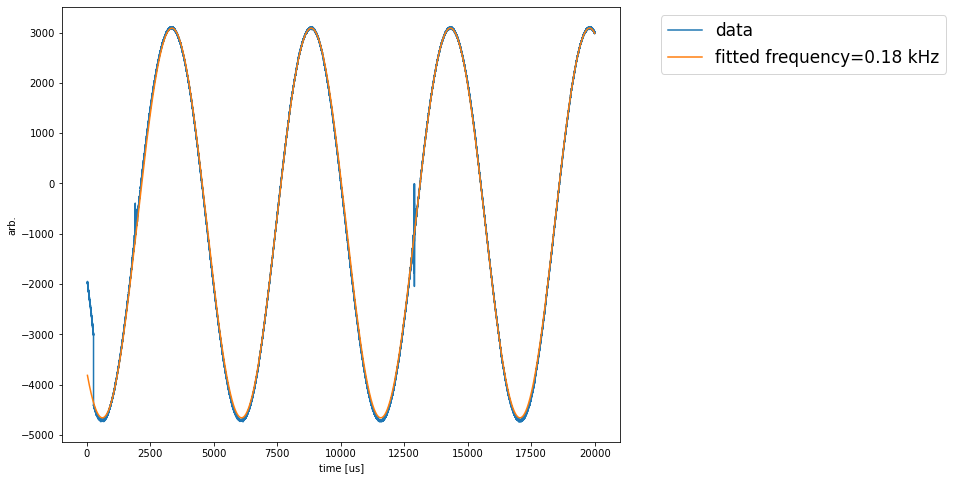

In [51]:
plt.figure(figsize=(10,8))
plt.plot(data['time_us'],data['sample'],label='data')

plt.ylabel('arb.')
plt.xlabel('time [us]')

fit_result= fit_sin(data['time_us'],data['sample'])
sin_func=fit_result['fitfunc']

plt.plot(data['time_us'],sin_func(data['time_us']), label='fitted frequency=%.2f kHz'%(fit_result['freq']*1000))

plt.legend(fontsize=17, loc='best', bbox_to_anchor=(1.6, 1),)

plt.show()

In [53]:
data.to_hdf('data.h5', key='df', mode='w')